In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Loading test output from the model and converting to time index

filename = r'Brunei_Champion7_GT4_tst_pred_01Mar2019_01Jul2019_w1d_m3hr.csv'
#dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv(filename, parse_dates = ['timestamp'])
df.set_index('timestamp', inplace = True)
df['date'] = df.index


In [5]:
# Changing -1 to 1 and 1 to 0 [1 denotes anomaly, 0 denotes normal]

df.prediction = df.prediction.replace(1, 0)
df.prediction = df.prediction.replace(-1, 1)

df['anomaly'] = 0
df.loc[(df['system_status'] == 'online') & (df['prediction'] == 1), 'anomaly'] = 1

df['sys_status'] = 0
df.loc[(df['system_status'] == 'online'), 'sys_status'] = 1

df['flips'] = 0
df.loc[(df['system_status'] == 'online') & (df['alert'] == 1) & (df['prediction'] == 1), 'flips'] = 1

df['counter_flips'] = 0
df.loc[(df['system_status'] == 'online') & (df['alert'] == 0) & (df['prediction'] == 1), 'counter_flips'] = 1


In [6]:
## Creating results dataframe

resultsdf = df[['anomaly','flips','counter_flips']].resample('M').sum()
resultsdf.columns = ['anomaly_count','flips_count','counter_flips_count']

x = df[['prediction', 'sys_status']].resample('M').count()

resultsdf['Total_counts'] = x['prediction']
resultsdf['anomaly_ratio'] = resultsdf['anomaly_count'] / resultsdf['Total_counts']
resultsdf['flips_ratio'] = resultsdf['flips_count'] / resultsdf['Total_counts']
resultsdf['counter_flips_ratio'] = resultsdf['counter_flips_count'] / resultsdf['Total_counts']

#resultsdf = resultsdf[resultsdf['Total_counts'] > 200]


In [7]:
len(resultsdf) #datapoints  

5

<IPython.core.display.Javascript object>


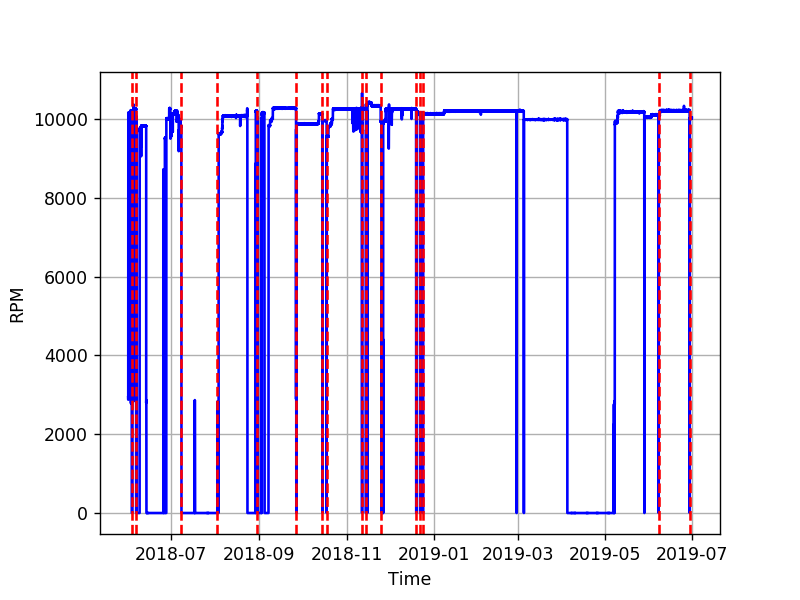

In [8]:
# Plotting entire dataset 

%matplotlib notebook

#dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
#pdf = pd.read_csv(r'gt4_master_data.csv',parse_dates=['timestamp'], date_parser = dateparse)
pdf = pd.read_csv(r'gt4_master_data.csv', parse_dates = ['timestamp'])
pdf.set_index('timestamp', inplace = True)

# Loading events_log 

dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
dffailure = pd.read_excel(r'GT4-downtime.xlsx', parse_dates = ['Trip Start Date'], date_parser = dateparse)
pdf = pdf[pdf.index <= resultsdf.index[-1]]

fig, ax1 = plt.subplots()

ax1.plot(pdf['CPCX07-DCS-GT4_XZA4754_NEW'], 'b-', label = 'RPM')
ax1.set_xlabel('Time')
ax1.set_ylabel('RPM')
ax1.grid(True)
for cnt in range(len(dffailure)):
    ax1.axvline(x = dffailure.loc[dffailure.index[cnt],'Trip Start Date'], color = 'r', linestyle = '--')
plt.show()


In [9]:
#resultsdf
resultsdf.drop(resultsdf.tail(1).index, inplace = True)

In [9]:
# Reloading the failure dataframe

dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
dffailure = pd.read_excel(r'GT4-downtime.xlsx', parse_dates = ['Trip Start Date'], date_parser = dateparse)
dffailure = dffailure[dffailure['Trip Start Date'] >= resultsdf.index[0]]
dffailure = dffailure[dffailure['Trip Start Date'] <= resultsdf.index[-1]]


<IPython.core.display.Javascript object>


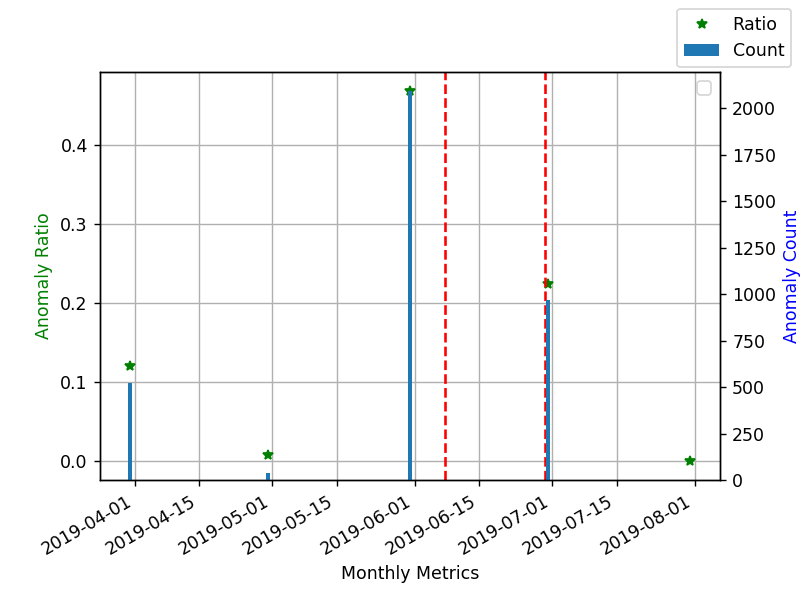

In [10]:
# Create anomaly ratio plot

fig, ax1 = plt.subplots()
fig.autofmt_xdate(bottom = 0.2, rotation = 30)

ax2 = ax1.twinx()
ax1.plot(resultsdf['anomaly_ratio'], 'g*', label = 'Ratio')
ax2.bar(resultsdf.index,resultsdf['anomaly_count'], label = 'Count')
ax1.set_xlabel('Monthly Metrics')
ax1.set_ylabel('Anomaly Ratio', color = 'g')
ax2.set_ylabel('Anomaly Count', color = 'b')
ax1.grid(True)
#ax2.grid('off')
fig.legend()
ax1.legend('Ratio','Count')
for cnt in range(len(dffailure)):
    ax1.axvline(x = dffailure.loc[dffailure.index[cnt],'Trip Start Date'], color = 'r', linestyle = '--')


plt.show() 

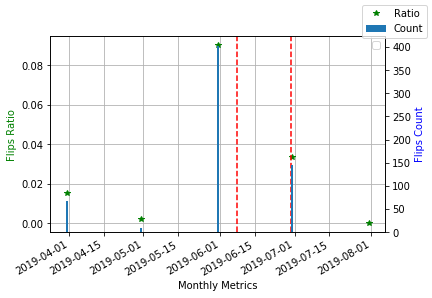

In [11]:
# Create flips ratio plot
%matplotlib inline

fig, ax1 = plt.subplots()
fig.autofmt_xdate(bottom = 0.2, rotation = 30)

ax2 = ax1.twinx()
ax1.plot(resultsdf['flips_ratio'], 'g*', label = 'Ratio')
ax2.bar(resultsdf.index, resultsdf['flips_count'], label = 'Count')

ax1.set_xlabel('Monthly Metrics')
ax1.set_ylabel('Flips Ratio', color = 'g')
ax2.set_ylabel('Flips Count', color = 'b')
ax1.grid(True)
#ax2.grid('off') 
fig.legend()
ax1.legend('Ratio','Count')
for cnt in range(len(dffailure)):
    ax1.axvline(x = dffailure.loc[dffailure.index[cnt],'Trip Start Date'], color = 'r', linestyle = '--')


plt.show()

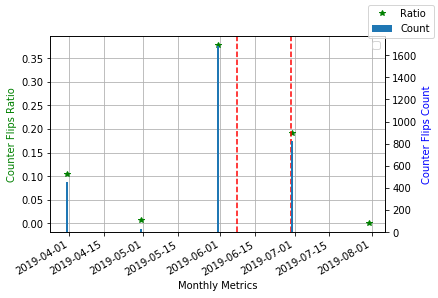

In [12]:
# Create counter_flips ratio plot

fig, ax1 = plt.subplots()
fig.autofmt_xdate(bottom = 0.2, rotation = 30)

ax2 = ax1.twinx()
ax1.plot(resultsdf['counter_flips_ratio'], 'g*',label = 'Ratio')
ax2.bar(resultsdf.index, resultsdf['counter_flips_count'], label = 'Count')

ax1.set_xlabel('Monthly Metrics')
ax1.set_ylabel('Counter Flips Ratio', color = 'g')
ax2.set_ylabel('Counter Flips Count', color = 'b')
ax1.grid(True)
#ax2.grid('off')
fig.legend()
ax1.legend('Ratio','Count')
for cnt in range(len(dffailure)):
    ax1.axvline(x = dffailure.loc[dffailure.index[cnt],'Trip Start Date'], color = 'r', linestyle = '--')


plt.show()

In [13]:
resultsdf

,anomaly_count,flips_count,counter_flips_count,Total_counts,anomaly_ratio,flips_ratio,counter_flips_ratio
timestamp,,,,,,,
2019-03-31,520,67,453,4320,0.120370,0.015509,0.104861
2019-04-30,36,9,27,4320,0.008333,0.002083,0.006250
2019-05-31,2090,403,1687,4464,0.468190,0.090278,0.377912
2019-06-30,970,145,825,4320,0.224537,0.033565,0.190972
2019-07-31,0,0,0,1,0.000000,0.000000,0.000000


In [16]:
# Validate counts from the test data output file (monthly)

df[['anomaly','flips','counter_flips']].resample('M').sum()

,anomaly,flips,counter_flips
timestamp,,,
2019-03-31,520,67,453
2019-04-30,36,9,27
2019-05-31,2090,403,1687
2019-06-30,970,145,825
2019-07-31,0,0,0
